# Reading and preparing data

In [2]:
import re
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can see that there are different data types:
__Categorical__: Survived, Sex, and Embarked. __Ordinal__: Pclass
__Continous__: Age, Fare __Discrete__: SibSp, Parch

In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Let's see which columns have gaps

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


We can see that there are some gaps in the 'Age' column. In addition, most cabin data is missing.
Gaps in the colums 'Fare' and 'Embarked' are not very significant, we can fill them easily

Let's look at different distributions

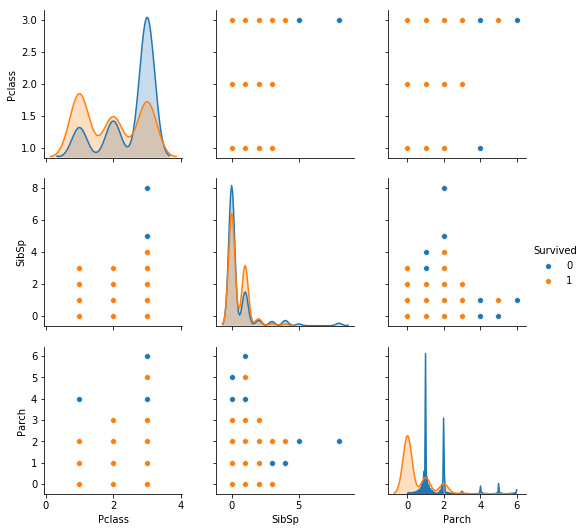

In [8]:
sb.pairplot(data=train, vars=['Pclass', 'SibSp', 'Parch'], hue="Survived", dropna=True)

It's obvious that it was easile to survive for people from 1 class that have parent(s) or sibling(s) on the board

In [9]:
print(train['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


Fill Embraked NA with S (most friquent value)

In [10]:
train['Embarked'] = train['Embarked'].fillna('S')

Now let's fill gaps in 'Age' column. The first idea is to fill NA with avarage value (like we did before with Embarked) But it's not so good as it seems, because we don't use a lot of information. For example, let's look at the names of people: Kelly, __Mr.__ James, Cumings, __Mrs.__ John Bradley, Heikkinen, __Miss.__ Laina...
Yes, we can use their titles to give them age more precisely!

In [11]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    else:
        return "None"

titles = train['Name'].apply(get_title).unique()
print(titles)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


Create new feature 'Title'

In [12]:
train['Title'] = train['Name'].apply(get_title)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Do it for test too

In [13]:
test['Title'] = test['Name'].apply(get_title)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


Calculate median age for every kind of title

In [14]:
ages = train.groupby("Title")["Age"].median()
print(ages)

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          46.5
Jonkheer    38.0
Lady        48.0
Major       48.5
Master       3.5
Miss        21.0
Mlle        24.0
Mme         24.0
Mr          30.0
Mrs         35.0
Ms          28.0
Rev         46.5
Sir         49.0
Name: Age, dtype: float64


In [15]:
train['Age'] = train.apply(lambda r: ages[r["Title"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)
test['Age'] = test.apply(lambda r: ages[r["Title"]] if pd.isnull(r["Age"]) else r["Age"], axis=1)

Now we will create the feature 'isCabin', because we cannot fill all gaps in this column in any way

In [16]:
train['isCabin'] = train.apply(lambda r: 0 if pd.isnull(r["Cabin"]) else 1, axis=1)
test['isCabin'] = test.apply(lambda r: 0 if pd.isnull(r["Cabin"]) else 1, axis=1)

Now we can drop names, tickets and cabines, we don't need it

In [17]:
train.drop(["Cabin", 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
test.drop(["Cabin", 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

There are only one empty data in the column 'Fare'. Fill it with avarage value

In [18]:
test["Fare"].fillna(test["Fare"].median(), inplace=True)

We need to categorize the data and we can train the model

In [19]:
train['Sex'] = train['Sex'].astype('category').cat.codes
test['Sex'] = test['Sex'].astype('category').cat.codes

train['Embarked'] = train['Embarked'].astype('category').cat.codes
test['Embarked'] = test['Embarked'].astype('category').cat.codes

train['Title'] = train['Title'].astype('category').cat.codes
test['Title'] = test['Title'].astype('category').cat.codes

In [20]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,isCabin
0,0,3,1,22.0,1,0,7.2500,2,12,0
1,1,1,0,38.0,1,0,71.2833,0,13,1
2,1,3,0,26.0,0,0,7.9250,2,9,0
3,1,1,0,35.0,1,0,53.1000,2,13,1
4,0,3,1,35.0,0,0,8.0500,2,12,0


Split on data and label

In [21]:
labels = train["Survived"]

train = train.drop(labels = ["Survived"],axis = 1)

And scale our date

In [22]:
scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,isCabin
0,1.0,1.0,0.452723,0.000,0.000000,0.015282,0.5,0.625,0.0
1,1.0,0.0,0.617566,0.125,0.000000,0.013663,1.0,0.750,0.0
2,0.5,1.0,0.815377,0.000,0.000000,0.018909,0.5,0.625,0.0
3,1.0,1.0,0.353818,0.000,0.000000,0.016908,1.0,0.625,0.0
4,1.0,0.0,0.287881,0.125,0.111111,0.023984,1.0,0.750,0.0


# XGBoost classification

In [23]:
def save_prediction(prediction, file_name):
    pd.DataFrame({"PassengerId":list(range(892, 1310)),"Survived":prediction}).to_csv(file_name,
                                                                                          index=False,header=True)

In [24]:
xgb_model = xgb.XGBClassifier()
xgb_params = [
    {"n_estimators": [230, 250, 270, 300, 330, 360],
     "max_depth": [1, 2, 3, 4],
     "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05]}
]
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, refit=True)
xgb_grid.fit(train, labels)
xgb_best = alg_xgb_grid.best_estimator_
print("Accuracy (xgboost auto): {} with params {}"
      .format(xgb_grid.best_score_, xgb_grid.best_params_))

KeyboardInterrupt: 

In [ ]:
xgb_prediction = xgb_grid.predict(test)    
save_prediction(xgb_prediction, 'xgb_prediction.csv')

# NN classification

In [156]:
train_split, test_split, y_train_split, y_test_split = train_test_split(train, labels, 
                                                                        test_size=0.1, random_state=42)

In [161]:
from keras.models import Sequential
from keras import layers

input_dim = train.shape[1]
print('Input dimension =', input_dim)

model = Sequential()
model.add(layers.Dense(10, kernel_initializer = 'uniform', input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(10, kernel_initializer = 'uniform', activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Input dimension = 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 10)                100       
_________________________________________________________________
dense_140 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_141 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_142 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_143 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_144 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_145 (Dense)            (None, 10)                1

In [162]:
history = model.fit(train, labels, epochs=200,
                    validation_data=(test_split, y_test_split))

Train on 891 samples, validate on 90 samples
Epoch 1/200
891/891 [==============================] - 2s 2ms/step - loss: 0.6897 - acc: 0.6162 - val_loss: 0.6876 - val_acc: 0.6000
Epoch 2/200
891/891 [==============================] - 0s 116us/step - loss: 0.6837 - acc: 0.6162 - val_loss: 0.6823 - val_acc: 0.6000
Epoch 3/200
891/891 [==============================] - 0s 131us/step - loss: 0.6775 - acc: 0.6162 - val_loss: 0.6779 - val_acc: 0.6000
Epoch 4/200
891/891 [==============================] - 0s 117us/step - loss: 0.6725 - acc: 0.6162 - val_loss: 0.6746 - val_acc: 0.6000
Epoch 5/200
891/891 [==============================] - 0s 119us/step - loss: 0.6683 - acc: 0.6162 - val_loss: 0.6713 - val_acc: 0.6000
Epoch 6/200
891/891 [==============================] - 0s 133us/step - loss: 0.6635 - acc: 0.6162 - val_loss: 0.6656 - val_acc: 0.6000
Epoch 7/200
891/891 [==============================] - 0s 109us/step - loss: 0.6554 - acc: 0.6162 - val_loss: 0.6527 - val_acc: 0.6000
Epoch 8/200


Epoch 61/200
891/891 [==============================] - 0s 112us/step - loss: 0.4578 - acc: 0.8148 - val_loss: 0.4063 - val_acc: 0.8667
Epoch 62/200
891/891 [==============================] - 0s 109us/step - loss: 0.4599 - acc: 0.8114 - val_loss: 0.3971 - val_acc: 0.8556
Epoch 63/200
891/891 [==============================] - 0s 108us/step - loss: 0.4587 - acc: 0.8193 - val_loss: 0.4080 - val_acc: 0.8667
Epoch 64/200
891/891 [==============================] - 0s 111us/step - loss: 0.4573 - acc: 0.8114 - val_loss: 0.3942 - val_acc: 0.8556
Epoch 65/200
891/891 [==============================] - 0s 149us/step - loss: 0.4529 - acc: 0.8137 - val_loss: 0.3969 - val_acc: 0.8667
Epoch 66/200
891/891 [==============================] - 0s 153us/step - loss: 0.4563 - acc: 0.8171 - val_loss: 0.3925 - val_acc: 0.8556
Epoch 67/200
891/891 [==============================] - 0s 110us/step - loss: 0.4546 - acc: 0.8137 - val_loss: 0.3941 - val_acc: 0.8556
Epoch 68/200
891/891 [==========================

891/891 [==============================] - 0s 102us/step - loss: 0.4244 - acc: 0.8260 - val_loss: 0.3749 - val_acc: 0.8667
Epoch 122/200
891/891 [==============================] - 0s 99us/step - loss: 0.4243 - acc: 0.8272 - val_loss: 0.3696 - val_acc: 0.8667
Epoch 123/200
891/891 [==============================] - 0s 110us/step - loss: 0.4234 - acc: 0.8305 - val_loss: 0.3754 - val_acc: 0.8667
Epoch 124/200
891/891 [==============================] - 0s 110us/step - loss: 0.4221 - acc: 0.8215 - val_loss: 0.3714 - val_acc: 0.8667
Epoch 125/200
891/891 [==============================] - 0s 178us/step - loss: 0.4208 - acc: 0.8227 - val_loss: 0.3671 - val_acc: 0.8667
Epoch 126/200
891/891 [==============================] - 0s 146us/step - loss: 0.4244 - acc: 0.8272 - val_loss: 0.3615 - val_acc: 0.8556
Epoch 127/200
891/891 [==============================] - 0s 147us/step - loss: 0.4216 - acc: 0.8283 - val_loss: 0.3635 - val_acc: 0.8667
Epoch 128/200
891/891 [==============================] -

Epoch 181/200
891/891 [==============================] - 0s 109us/step - loss: 0.4083 - acc: 0.8238 - val_loss: 0.3568 - val_acc: 0.8778
Epoch 182/200
891/891 [==============================] - 0s 108us/step - loss: 0.4089 - acc: 0.8316 - val_loss: 0.3691 - val_acc: 0.8778
Epoch 183/200
891/891 [==============================] - 0s 127us/step - loss: 0.4075 - acc: 0.8384 - val_loss: 0.3662 - val_acc: 0.8889
Epoch 184/200
891/891 [==============================] - 0s 105us/step - loss: 0.4100 - acc: 0.8328 - val_loss: 0.3663 - val_acc: 0.8778
Epoch 185/200
891/891 [==============================] - 0s 154us/step - loss: 0.4087 - acc: 0.8238 - val_loss: 0.3716 - val_acc: 0.8778
Epoch 186/200
891/891 [==============================] - 0s 127us/step - loss: 0.4112 - acc: 0.8373 - val_loss: 0.3684 - val_acc: 0.8778
Epoch 187/200
891/891 [==============================] - 0s 124us/step - loss: 0.4081 - acc: 0.8350 - val_loss: 0.3603 - val_acc: 0.8667
Epoch 188/200
891/891 [==================

In [163]:
loss, accuracy = model.evaluate(test_split, y_test_split, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_split, y_test_split, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8778
Testing Accuracy:  0.8778


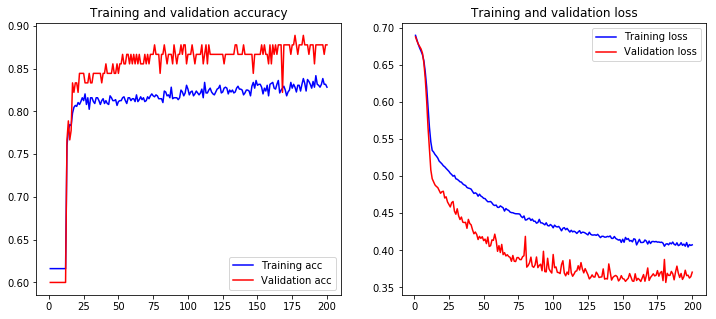

In [164]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [165]:
prediction = np.around(model.predict(test), decimals=0)
save_prediction(prediction[:,0].astype(int), 'result_nn.csv')